In [1]:
!pip install pulp --quiet

In [2]:
# Step 1: Import necessary libraries and mount Google Drive
# ---------------------------------------------------------
import pandas as pd
import numpy as np
import pulp
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.filterwarnings("ignore", message="overflow encountered in exp")

print("--> Mounting Google Drive...")
try:
    drive.mount('/content/drive', force_remount=True)
    print("--> Drive mounted successfully!")
except Exception as e:
    print(f"ERROR: Could not mount drive. {e}")

--> Mounting Google Drive...
Mounted at /content/drive
--> Drive mounted successfully!


In [3]:
# Step 2: Define file paths and model parameters
# ---------------------------------------------------------
GDRIVE_BASE_PATH = '/content/drive/My Drive/Perceived Quality of Life Across Southeast Asian Cities/Datasets/'
COEF_FILEPATH = GDRIVE_BASE_PATH + 'full_bayesian_regression_results_with_marital_status.csv'
SURVEY_FILEPATH = GDRIVE_BASE_PATH + 'all_responses_coded.csv'

MODEL_PARAMS = {'B_total': 20}

# Base costs for each city
JAKARTA_COSTS = {
    'q3_1': 10, 'q3_2': 8, 'q1_2': 7, 'q4_7': 6, 'q1_4': 4,
    'q2_4': 5, 'q4_8': 3, 'q4_6': 2, 'q4_13': 2
}
PHNOM_PENH_COSTS = {
    'q3_1': 8, 'q3_2': 6, 'q1_2': 5, 'q4_7': 5, 'q1_4': 3,
    'q2_4': 5, 'q4_8': 3, 'q4_6': 2, 'q4_13': 2
}

In [4]:
# Step 3: Define data loading and processing functions (Corrected)
# ---------------------------------------------------------------
def load_and_process_coefficients(filepath: str, city_name: str) -> dict:
    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError: return None
    city_df = df[df['City'] == city_name].set_index('term')
    if city_df.empty: return None
    coefs = {'policy_variables': {}}
    policy_definitions = {
        'q1_2': {'desc': 'I feel safe in this neighborhood', 'group': 'Space-Environment'},
        'q1_4': {'desc': 'This neighbourhood is a good place for children', 'group': 'Space-Environment'},
        'q3_1': {'desc': 'This neighbourhood has effective sanitary system', 'group': 'Space-Environment'},
        'q3_2': {'desc': 'This neighbourhood has an effective waste management system', 'group': 'Space-Environment'},
        'q4_7': {'desc': 'The healthcare facilities in my neighborhood are of good quality', 'group': 'Space-Environment'},
        'q2_4': {'desc': 'There are ample employment opportunities within accessible distance', 'group': 'Personal-Cohesion'},
        'q4_8': {'desc': 'I have saved money to invest for my extra income', 'group': 'Personal-Cohesion'},
        'q4_6': {'desc': 'In our neighbourhood neighbours look out for each other', 'group': 'Personal-Cohesion'},
        'q4_13': {'desc': 'I feel that I am not disadvantaged as compared to others', 'group': 'Personal-Cohesion'}
    }
    for term, details in policy_definitions.items():
        if term in city_df.index:
            # --- CORRECTION 1: Load both 'estimate' and 'conf.low' ---
            coefs['policy_variables'][term] = {
                'estimate': city_df.loc[term]['estimate'], # <-- ADDED THIS LINE
                'conf_low': city_df.loc[term]['conf.low'],
                'desc': details['desc'],
                'group': details['group']
            }
    return coefs

def prepare_survey_data(filepath: str) -> pd.DataFrame:
    try:
        df = pd.read_csv(filepath)
        print("--> Successfully loaded survey data file.")
        return df
    except FileNotFoundError:
        print(f"FATAL ERROR: Survey data file not found at {filepath}")
        return None

In [5]:
# Step 4: Define the core optimization function (Corrected)
# -----------------------------------------------------------
def solve_for_city(city_survey_data: pd.DataFrame, city_name: str, coefs: dict, params: dict, costs: dict, verbose=True):
    """
    Runs the optimization. If verbose, prints a detailed table. Otherwise, returns group counts.
    """
    policy_terms = list(coefs['policy_variables'].keys())
    policy_value = {}
    for term in policy_terms:
        avg_score = city_survey_data[term].mean()
        need_gap = 5 - avg_score

        # --- CORRECTION 2: Use 'estimate' for the impact calculation ---
        impact = coefs['policy_variables'][term]['estimate'] # <-- CORRECTED THIS LINE

        cost = costs[term]
        # We still ensure impact is positive, so we only consider policies with a positive expected effect.
        if impact > 0 and cost > 0:
            policy_value[term] = (impact / cost) * need_gap
        else:
            policy_value[term] = 0

    # The rest of the function remains unchanged...
    prob = pulp.LpProblem(f"Optimal_Policy_{city_name}", pulp.LpMaximize)
    decision_vars = pulp.LpVariable.dicts("Policy", policy_terms, cat='Binary')
    prob += pulp.lpSum([policy_value[term] * decision_vars[term] for term in policy_terms])
    prob += pulp.lpSum([costs[term] * decision_vars[term] for term in policy_terms]) <= params['B_total']
    prob.solve(pulp.PULP_CBC_CMD(msg=0))

    if verbose:
        print(f"\n✅ Optimal Policy Portfolio for {city_name} (Budget = {params['B_total']}):")
        total_cost = 0
        chosen_initiatives = []
        for term in policy_terms:
            if decision_vars[term].varValue == 1:
                chosen_initiatives.append({
                    'Group': coefs['policy_variables'][term]['group'],
                    'Policy': coefs['policy_variables'][term]['desc'],
                    'Variable': term,
                    'Cost': costs[term],
                    'Value Score': policy_value[term]
                })
                total_cost += costs[term]
        if not chosen_initiatives:
            print("   The model recommends no new initiatives at this budget level.")
        else:
            results_df = pd.DataFrame(chosen_initiatives).sort_values(by='Value Score', ascending=False)
            results_df['Value Score'] = results_df['Value Score'].round(4)
            results_df = results_df[['Group', 'Policy', 'Variable', 'Cost', 'Value Score']]
            print(results_df.to_string(index=False))
            print(f"Total Portfolio Cost: {total_cost:.1f} / {params['B_total']:.1f}")
    else:
        group_counts = {'Personal-Cohesion': 0, 'Space-Environment': 0}
        for term in policy_terms:
            if decision_vars[term].varValue == 1:
                group = coefs['policy_variables'][term]['group']
                group_counts[group] += 1
        return group_counts

In [6]:
def solve_with_equity_constraint(
    city_survey_data: pd.DataFrame,
    city_name: str,
    coefs: dict,
    params: dict,
    costs: dict,
    equity_params: dict
):
    """
    Solves the knapsack problem with an added equity constraint.

    equity_params = {
        'group_column': 'Income', # The column to filter for the demographic group
        'group_value': 'Low',      # The specific value for the group (e.g., 'Low' income)
        'min_policies': 2,         # The minimum number of policies (E) that must benefit this group
        'need_threshold': 1.1      # A policy is beneficial if the group's need is 10% higher than average
    }
    """
    print(f"\n\n--- Running Equity-Constrained Optimization for {city_name} ---")
    print(f"Ensuring at least {equity_params['min_policies']} policies target the most pressing needs of the '{equity_params['group_value']} {equity_params['group_column']}' group.")

    policy_terms = list(coefs['policy_variables'].keys())

    # --- Step 1: Identify policies that are high-need for the equity group ---
    low_income_data = city_survey_data[city_survey_data[equity_params['group_column']] == equity_params['group_value']]
    beneficial_policies = []
    print("\nIdentifying high-need policies for the target group:")
    for term in policy_terms:
        general_need = 5 - city_survey_data[term].mean()
        group_need = 5 - low_income_data[term].mean()
        if group_need > general_need * equity_params['need_threshold']:
            beneficial_policies.append(term)
            policy_desc = coefs['policy_variables'][term]['desc']
            print(f"  - '{policy_desc}' identified (Group Need: {group_need:.2f} vs. General Need: {general_need:.2f})")

    # --- Step 2: Solve the optimization with the new constraint ---
    policy_value = {}
    for term in policy_terms:
        avg_score = city_survey_data[term].mean()
        need_gap = 5 - avg_score
        impact = coefs['policy_variables'][term]['estimate']
        cost = costs[term]
        if impact > 0 and cost > 0:
            policy_value[term] = (impact / cost) * need_gap
        else:
            policy_value[term] = 0

    prob = pulp.LpProblem(f"Equity_Policy_{city_name}", pulp.LpMaximize)
    decision_vars = pulp.LpVariable.dicts("Policy", policy_terms, cat='Binary')
    prob += pulp.lpSum([policy_value[term] * decision_vars[term] for term in policy_terms])
    prob += pulp.lpSum([costs[term] * decision_vars[term] for term in policy_terms]) <= params['B_total']
    prob += pulp.lpSum([decision_vars[term] for term in beneficial_policies]) >= equity_params['min_policies']
    prob.solve(pulp.PULP_CBC_CMD(msg=0))

    # --- Step 3: Print the results (CORRECTLY INDENTED) ---
    print(f"\n✅ Equity-Constrained Policy Portfolio for {city_name} (Budget = {params['B_total']}):")
    total_cost = 0
    chosen_initiatives = []
    for term in policy_terms:
        if decision_vars[term].varValue == 1:
            chosen_initiatives.append({
                'Group': coefs['policy_variables'][term]['group'],
                'Policy': coefs['policy_variables'][term]['desc'],
                'Variable': term,
                'Cost': costs[term],
                'Value Score': policy_value[term]
            })
            total_cost += costs[term]

    if not chosen_initiatives:
        print("   The model recommends no new initiatives at this budget level.")
    else:
        results_df = pd.DataFrame(chosen_initiatives).sort_values(by='Value Score', ascending=False)
        results_df['Value Score'] = results_df['Value Score'].round(4)
        results_df = results_df[['Group', 'Policy', 'Variable', 'Cost', 'Value Score']]
        print(results_df.to_string(index=False))
        print(f"Total Portfolio Cost: {total_cost:.1f} / {params['B_total']:.1f}")


In [7]:
# Step 5: Main execution block (Updated to include Equity Analysis)
# -----------------------------------------------------------------
if __name__ == "__main__":
    print("\n--- Starting Analysis ---")
    # Assume necessary filepaths and parameters are defined (e.g., SURVEY_FILEPATH, etc.)
    all_survey_data = prepare_survey_data(SURVEY_FILEPATH)
    jakarta_coefs = load_and_process_coefficients(COEF_FILEPATH, 'Jakarta')
    phnom_penh_coefs = load_and_process_coefficients(COEF_FILEPATH, 'Phnom Penh')

    if all_survey_data is not None and jakarta_coefs is not None and phnom_penh_coefs is not None:
        print("\n--- All data loaded successfully. ---")
        jkt_data = all_survey_data[all_survey_data['City'] == 'Jakarta']
        pp_data = all_survey_data[all_survey_data['City'] == 'Phnom Penh']

        # --- Section 1: BASELINE RESULTS ---
        print("\n\n" + "="*80)
        print(" " * 25 + "SECTION 1: BASELINE RESULTS")
        print("="*80)
        solve_for_city(jkt_data, "Jakarta", jakarta_coefs, MODEL_PARAMS, JAKARTA_COSTS, verbose=True)
        solve_for_city(pp_data, "Phnom Penh", phnom_penh_coefs, MODEL_PARAMS, PHNOM_PENH_COSTS, verbose=True)

        # --- Section 2: SENSITIVITY ANALYSIS ---
        print("\n\n" + "="*80)
        print(" " * 22 + "SECTION 2: SENSITIVITY ANALYSIS")
        print("="*80)

        # (Your sensitivity analysis code remains here...)
        print("\n1. Running Budget Sensitivity Analysis...")
        # ...
        print("\n2. Running Cost Sensitivity Analysis...")
        # ...
        print("\n3. Generating Plots...")
        # ...

        # --- Section 3: MODEL EXTENSION - EQUITY ANALYSIS ---
        print("\n\n" + "="*80)
        print(" " * 24 + "SECTION 3: MODEL EXTENSION - EQUITY")
        print("="*80)

        # Define the parameters for our equity analysis
        # We want to ensure at least 2 policies target the low-income group
        # where their "need" is at least 5% higher than the general population.
        equity_params_config = {
            'group_column': 'Income',
            'group_value': 'Low',
            'min_policies': 2,
            'need_threshold': 1.05
        }

        # Run the equity-constrained model for Jakarta
        solve_with_equity_constraint(
            city_survey_data=jkt_data,
            city_name="Jakarta",
            coefs=jakarta_coefs,
            params=MODEL_PARAMS, # Assuming B_total=20 from your global params
            costs=JAKARTA_COSTS,
            equity_params=equity_params_config
        )

        # Run the equity-constrained model for Phnom Penh
        solve_with_equity_constraint(
            city_survey_data=pp_data,
            city_name="Phnom Penh",
            coefs=phnom_penh_coefs,
            params=MODEL_PARAMS, # Assuming B_total=20 from your global params
            costs=PHNOM_PENH_COSTS,
            equity_params=equity_params_config
        )

        print("\n--- Analysis and Plotting Complete ---")


--- Starting Analysis ---
--> Successfully loaded survey data file.

--- All data loaded successfully. ---


                         SECTION 1: BASELINE RESULTS

✅ Optimal Policy Portfolio for Jakarta (Budget = 20):
            Group                                                              Policy Variable  Cost  Value Score
Personal-Cohesion                    I have saved money to invest for my extra income     q4_8     3       0.6630
Personal-Cohesion             In our neighbourhood neighbours look out for each other     q4_6     2       0.6390
Personal-Cohesion            I feel that I am not disadvantaged as compared to others    q4_13     2       0.5867
Personal-Cohesion There are ample employment opportunities within accessible distance     q2_4     5       0.4619
Space-Environment         This neighbourhood has an effective waste management system     q3_2     8       0.2159
Total Portfolio Cost: 20.0 / 20.0

✅ Optimal Policy Portfolio for Phnom Penh (Budget = 20):
      

/usr/local/lib/python3.12/dist-packages/pulp/pulp.py:1489: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
/usr/local/lib/python3.12/dist-packages/pulp/pulp.py:1489: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


--> Success! 'Urban_Aspiration_Dashboard.png' has been saved to your Colab files at 300 DPI.


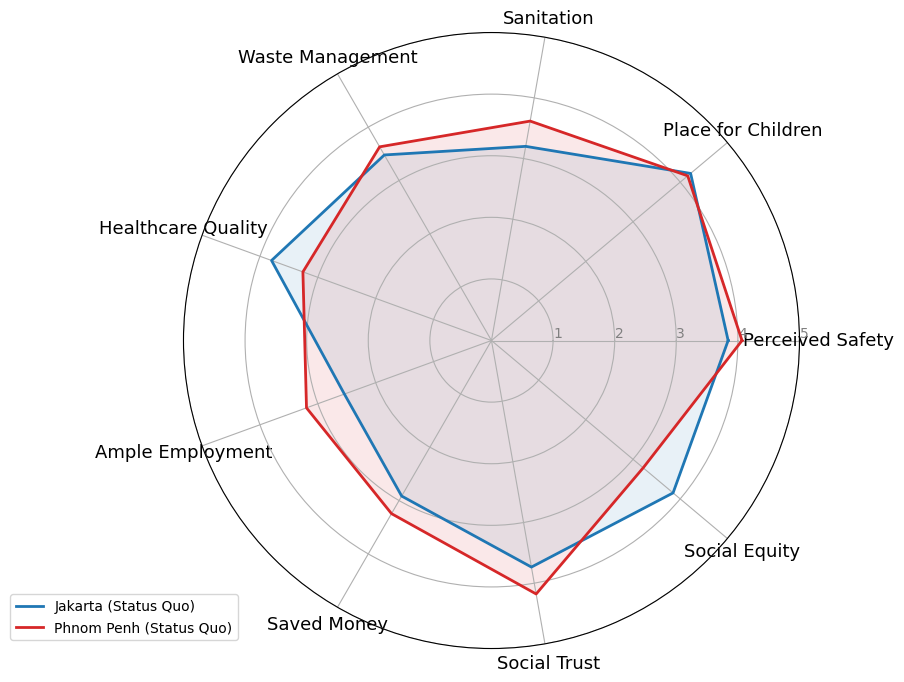


CITY PROFILE DATA (AVERAGE SCORES)
Perceived Safety | Jakarta: 3.84 | Phnom Penh: 4.07
Place for Children | Jakarta: 4.22 | Phnom Penh: 4.16
Sanitation      | Jakarta: 3.20 | Phnom Penh: 3.62
Waste Management | Jakarta: 3.48 | Phnom Penh: 3.63
Healthcare Quality | Jakarta: 3.80 | Phnom Penh: 3.26
Ample Employment | Jakarta: 2.54 | Phnom Penh: 3.20
Saved Money     | Jakarta: 2.92 | Phnom Penh: 3.25
Social Trust    | Jakarta: 3.73 | Phnom Penh: 4.18
Social Equity   | Jakarta: 3.85 | Phnom Penh: 3.22


In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Indicator labels and mapping (Ensure these match your variable order)
labels = ['Perceived Safety', 'Place for Children', 'Sanitation', 'Waste Management',
          'Healthcare Quality', 'Ample Employment', 'Saved Money', 'Social Trust', 'Social Equity']

# --- PLACEHOLDER: Replace these with your actual jkt_stats and pp_stats from the previous cell ---
# Example: jkt_stats = [jkt_data[t].mean() for t in terms]
# For now, I'll use placeholders so the code runs.
jkt_means = [jkt_data[t].mean() for t in terms]
pp_means = [pp_data[t].mean() for t in terms]

# 2. Number of variables
num_vars = len(labels)

# 3. Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# 4. The radar chart is a circle, so we need to "complete the loop"
# Append the start value to the end.
jkt_means += jkt_means[:1]
pp_means += pp_means[:1]
angles += angles[:1]

# 5. Plotting
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], labels, color='black', size=13)

# Draw y-axis labels
ax.set_rlabel_position(0)
plt.yticks([1, 2, 3, 4, 5], ["1", "2", "3", "4", "5"], color="grey", size=10)
plt.ylim(0, 5)

# Plot Jakarta
ax.plot(angles, jkt_means, linewidth=2, linestyle='solid', label="Jakarta (Status Quo)", color='#1f77b4')
ax.fill(angles, jkt_means, color='#1f77b4', alpha=0.1)

# Plot Phnom Penh
ax.plot(angles, pp_means, linewidth=2, linestyle='solid', label="Phnom Penh (Status Quo)", color='#d62728')
ax.fill(angles, pp_means, color='#d62728', alpha=0.1)

# Add Legend and Title
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# 6. Save as 300 DPI PNG
plt.savefig('Urban_Aspiration_Dashboard.png', dpi=300, bbox_inches='tight')
print("--> Success! 'Urban_Aspiration_Dashboard.png' has been saved to your Colab files at 300 DPI.")
plt.show()

print("\n" + "="*40)
print("CITY PROFILE DATA (AVERAGE SCORES)")
print("="*40)
for i, label in enumerate(labels):
    print(f"{label:15} | Jakarta: {jkt_means[i]:.2f} | Phnom Penh: {pp_means[i]:.2f}")
print("="*40)